In [4]:
import pandas as pd
%cd '~/git/nogitfile'
!ls
ori_df = pd.read_csv('train.csv')

### 看有幾個column
print(f'-共有{ori_df.shape[0]}筆資料')
#print('-共有{0}筆資料'.format(df.shape[0]))
print('-分布於%d欄'%ori_df.shape[1])
import numpy as np
def timeSinCosTrans(df):

    Time = df.loc[:,'loctm'].values
    # // 是整除的意思
    s, m, h = [(Time//100**(i)%100) for i in range(3)]
    Time = h*3600+m*60+s

    dfTime = pd.DataFrame()
    dfTime.loc[:,'TIME_SIN'] = np.sin(2*np.pi*Time/(24*60*60))
    dfTime.loc[:,'TIME_COS'] = np.cos(2*np.pi*Time/(24*60*60))
    dfTime.loc[:,'time'] = Time

    #df.drop(columns = 'loctm', inplace =True)
    df = pd.concat([df, dfTime], axis = 1)

    return df

/home/jovyan/git/nogitfile
dataset_description.pdf  submit_11-07:15:54.csv  train.csv
submit_11-07:14:04.csv	 test.csv
-共有1521787筆資料
-分布於23欄


In [5]:
def submit():

    test_df = pd.read_csv('test.csv')
    #rint(len(test_df))
    ID = test_df['txkey']


   # to_drop = ['bacno','txkey','cano']
   # test_df = test_df.drop(columns=to_drop)

    #print(test_df.info())
    test_df = timeSinCosTrans(test_df)

   # print(len(test_df))
    test_df.fillna(0, inplace = True)

    test = test_df

    YN = ['ecfg','flbmk', 'flg_3dsmk', 'insfg', 'ovrlt']
    for col in YN:
        test.loc[test[col] =='N', col] = 0
        test.loc[test[col] =='Y', col] = 1


    

    label = model.predict(test)

    from datetime import datetime
    time_str = datetime.now().strftime('%m-%d:%H:%M')

    submit = {'txkey':ID, 'fraud_ind':label}
    pd.DataFrame(data= submit).to_csv('submit_'+time_str+'.csv',index = False)

### 基礎資料處理

In [6]:
df = ori_df.copy()

# 把Y/N 資料轉成 0/1
YN = ['ecfg','flbmk', 'flg_3dsmk', 'insfg', 'ovrlt']
for col in YN:
    df.loc[df[col] =='N', col] = 0
    df.loc[df[col] =='Y', col] = 1
df.fillna(0, inplace =True)

# 把時間做sin/cos轉換，保留原來時間
df = timeSinCosTrans(df)


#### 抓出所有被詐騙過的帳戶進行分析

In [7]:
fraud_df = df.loc[df['fraud_ind'] == 1]
print("總共的詐騙次數共有%d筆"%len(fraud_df))
fraud_bacno_list = list(set(fraud_df['bacno']))

new_df = df[df['bacno'].isin(fraud_bacno_list)]

print("所有被詐騙帳戶的資料有%d筆"%len(new_df))
new_df.head()

總共的詐騙次數共有20355筆
所有被詐騙帳戶的資料有255579筆


,acqic,bacno,cano,conam,contp,csmcu,ecfg,etymd,flbmk,flg_3dsmk,...,mcc,mchno,ovrlt,scity,stocn,stscd,txkey,TIME_SIN,TIME_COS,time
0,6881,113261,38038,513.80,5,0,0,0,0,0,...,457,59333,0,0,102,0,516056,-0.989568,-0.144068,62812.0
16,6716,150887,4541,930.31,5,62,0,4,0,0,...,329,37560,0,5820,102,0,1765957,-0.575243,-0.817982,51628.0
19,6881,152257,65948,513.80,5,0,0,0,0,0,...,457,68930,0,0,102,0,485608,-0.819110,-0.573636,56399.0
23,6881,161031,145047,683.25,5,0,0,0,0,0,...,457,86584,0,0,102,0,486692,-0.086214,-0.996277,44387.0
30,6769,21246,88760,500.14,5,62,0,4,0,0,...,292,79111,0,5817,102,0,395453,-0.959744,0.280876,68715.0


In [8]:
from sklearn.model_selection import train_test_split

# df = new_df.copy()
y = new_df.pop('fraud_ind')
X_data, X_test, y_data, y_test = train_test_split(new_df, y, train_size = .9, stratify = y, random_state = 20)



In [ ]:
# 訓練模型評估結果
from sklearn.model_selection import StratifiedKFold 
import xgboost as xgb
from sklearn.metrics import f1_score
import sklearn.model_selection


skf = StratifiedKFold(n_splits=2, random_state=123, shuffle=True)
skf.get_n_splits(X_data, y_data)
print(skf)  



for train_index, test_index in skf.split(X_data, y_data):
    
    print("TRAIN:", train_index, "TEST:", test_index)  
    X_train, X_valid = X_data[X_data.index.isin(train_index)], X_data[X_data.index.isin(test_index)]
    y_train, y_valid = y_data[y_data.index.isin(train_index)], y_data[y_data.index.isin(test_index)]
    
#     print(X_train)
    model = xgb.XGBClassifier(max_depth= '8', learning_rate=.05, n_estimators = 1000,\
                          tree_method = 'gpu_hist', predictor = 'gpu_predictor')
    
    model.fit(X=X_train,y=y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose = False)

    y_true = y_valid.values
    y_pred = model.predict(X_valid)
    print(f1_score(y_true, y_pred, average=None))

### 訓練模型評估結果

In [ ]:
# 提交
submit()

### 

### 分析
1. 有詐騙的帳戶漢沒有詐騙的帳戶之間的異同 (麻煩)
2. 被詐騙的帳戶資料之間的變化

7.0

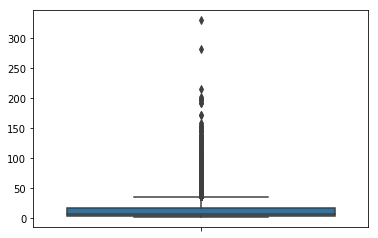

In [89]:
cano_list = list(set(X_data['cano']))
len(set(X_data['cano']))

lis = []
for i in cano_list:
    tdf = X_data[X_data['cano'] == i]
    lis.append([i, len(tdf)])
#         print(i,len(tdf))

fraud_cano = np.array(lis)
import numpy as np
np.mean(fraud_cano[:,1])
np.max(fraud_cano[:,1])
sns.boxplot(list(fraud_cano[:,1]), orient ='v')
np.median(fraud_cano[:,1])

In [14]:
new_df[new_df['bacno'] == 113261]
len(new_df[ new_df['bacno']== 113261])

80

In [18]:
a = new_df[ new_df['bacno']== 113261]
a.columns

Index(['acqic', 'bacno', 'cano', 'conam', 'contp', 'csmcu', 'ecfg', 'etymd',
       'flbmk', 'flg_3dsmk', 'hcefg', 'insfg', 'iterm', 'locdt', 'loctm',
       'mcc', 'mchno', 'ovrlt', 'scity', 'stocn', 'stscd', 'txkey', 'TIME_SIN',
       'TIME_COS', 'time'],
      dtype='object')

In [28]:
set(a['locdt'])
len(set(a['locdt']))

lis_locdt=list(set(a['locdt']))
print(lis_locdt)

[1, 5, 6, 9, 10, 11, 13, 15, 16, 17, 20, 21, 23, 26, 30, 33, 34, 36, 37, 39, 44, 45, 49, 50, 60, 69, 70, 71, 74, 75, 76, 77, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90]


In [38]:
lis_bac_day = []

In [39]:

for i in lis_locdt:
#     print(i) # i = 日期
    locdt_i = a[ a['locdt']==i] 
    #print(len(locdt_i)) #當天交易數量
    #lis_bac_day.append(len(locdt_i))
    lis_bac_day.append([i, len(locdt_i)])

In [40]:
lis_bac_day

[[1, 1],
 [5, 1],
 [6, 1],
 [9, 1],
 [10, 1],
 [11, 1],
 [13, 1],
 [15, 1],
 [16, 1],
 [17, 1],
 [20, 1],
 [21, 1],
 [23, 2],
 [26, 1],
 [30, 3],
 [33, 4],
 [34, 2],
 [36, 3],
 [37, 1],
 [39, 1],
 [44, 1],
 [45, 2],
 [49, 4],
 [50, 1],
 [60, 2],
 [69, 1],
 [70, 1],
 [71, 1],
 [74, 2],
 [75, 2],
 [76, 2],
 [77, 1],
 [79, 3],
 [80, 3],
 [81, 2],
 [82, 1],
 [83, 3],
 [84, 3],
 [85, 3],
 [86, 1],
 [87, 2],
 [88, 2],
 [89, 2],
 [90, 6]]

In [46]:
a[a['locdt'] == 90].index
y[y.index.isin(a[a['locdt'] == 90].index)]

162955     0
551140     0
781145     0
850023     0
923677     1
1023622    0
Name: fraud_ind, dtype: int64

In [60]:
df_bac_loc = a.copy()

In [61]:
a.head()

,acqic,bacno,cano,conam,contp,csmcu,ecfg,etymd,flbmk,flg_3dsmk,...,mcc,mchno,ovrlt,scity,stocn,stscd,txkey,TIME_SIN,TIME_COS,time
0,6881,113261,38038,513.80,5,0,0,0,0,0,...,457,59333,0,0,102,0,516056,-0.989568,-0.144068,62812.0
16628,6292,113261,38038,612.50,5,62,1,2,0,0,...,209,38206,0,5817,102,0,1354349,-0.688196,0.725525,75963.0
18097,6881,113261,38038,513.80,5,0,0,0,0,0,...,457,59333,0,0,102,0,516052,-0.989155,-0.146874,62773.0
27691,6716,113261,38038,1467.41,5,62,1,2,0,0,...,248,34217,0,5820,102,0,933876,-0.247140,0.968980,82966.0
34354,6581,113261,38038,403.35,5,62,0,5,0,0,...,263,3023,0,5817,102,0,1433954,-0.788905,0.614515,73900.0


In [62]:
df_bac_loc.head()

,acqic,bacno,cano,conam,contp,csmcu,ecfg,etymd,flbmk,flg_3dsmk,...,mcc,mchno,ovrlt,scity,stocn,stscd,txkey,TIME_SIN,TIME_COS,time
0,6881,113261,38038,513.80,5,0,0,0,0,0,...,457,59333,0,0,102,0,516056,-0.989568,-0.144068,62812.0
16628,6292,113261,38038,612.50,5,62,1,2,0,0,...,209,38206,0,5817,102,0,1354349,-0.688196,0.725525,75963.0
18097,6881,113261,38038,513.80,5,0,0,0,0,0,...,457,59333,0,0,102,0,516052,-0.989155,-0.146874,62773.0
27691,6716,113261,38038,1467.41,5,62,1,2,0,0,...,248,34217,0,5820,102,0,933876,-0.247140,0.968980,82966.0
34354,6581,113261,38038,403.35,5,62,0,5,0,0,...,263,3023,0,5817,102,0,1433954,-0.788905,0.614515,73900.0


In [63]:
# df_bac_loc = df_bac_loc.pop('locdt')

In [86]:
df_bac_loc.loc['acqic']

KeyError: 'acqic'